Context

The Ramen Rater is a product review website for the hardcore ramen enthusiast (or "ramenphile"), with over 2500 reviews to date. This dataset is an export of "The Big List" (of reviews), converted to a CSV format.

Content

Each record in the dataset is a single ramen product review. Review numbers are contiguous: more recently reviewed ramen varieties have higher numbers. Brand, Variety (the product name), Country, and Style (Cup? Bowl? Tray?) are pretty self-explanatory. Stars indicate the ramen quality, as assessed by the reviewer, on a 5-point scale; this is the most important column in the dataset!

Note that this dataset does not include the text of the reviews themselves. For that, you should browse through https://www.theramenrater.com/ instead!

Acknowledgements

This dataset is republished as-is from the original BIG LIST on https://www.theramenrater.com/.



In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import math
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', None)
df_raw = pd.read_csv('ramen-ratings.csv', low_memory = False)
df_raw.head(100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN
...,...,...,...,...,...,...,...
95,2485,Nissin,Cup Noodles Shrimps,Cup,Germany,3,NaN
96,2484,Nissin,Demae Ramen Tokyo Soy Sauce,Pack,Germany,4,NaN
97,2483,Paldo,Bul Jjamppong,Bowl,South Korea,5,NaN
98,2482,TTL,Chicken With Chinese Shaoxing Wine,Pack,Taiwan,4.75,NaN


Dropping Top Ten column since all values are NaN.

In [6]:
df_raw = df_raw.drop(columns=['Top Ten'])

In [7]:
df_raw = df_raw.drop(columns=['Review #'])

In [8]:
df_raw.head()

,Brand,Variety,Style,Country,Stars
0,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75
1,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1
2,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25
3,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75
4,Ching's Secret,Singapore Curry,Pack,India,3.75


In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [10]:
display_all(df_raw.tail())

,Brand,Variety,Style,Country,Stars
2575,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Sty...",Bowl,Vietnam,3.5
2576,Wai Wai,Oriental Style Instant Noodles,Pack,Thailand,1
2577,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2
2578,Wai Wai,Tom Yum Chili Flavor,Pack,Thailand,2
2579,Westbrae,Miso Ramen,Pack,USA,0.5


In [11]:
display_all(df_raw.tail().T)

,2575,2576,2577,2578,2579
Brand,Vifon,Wai Wai,Wai Wai,Wai Wai,Westbrae
Variety,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Sty...",Oriental Style Instant Noodles,Tom Yum Shrimp,Tom Yum Chili Flavor,Miso Ramen
Style,Bowl,Pack,Pack,Pack,Pack
Country,Vietnam,Thailand,Thailand,Thailand,USA
Stars,3.5,1,2,2,0.5


In [12]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq
Brand,2580,355,Nissin,381
Variety,2580,2413,Chicken,7
Style,2578,7,Pack,1531
Country,2580,38,Japan,352
Stars,2580,51,4,384


In [13]:
df_raw["Stars"]

0       3.75
1          1
2       2.25
3       2.75
4       3.75
        ... 
2575     3.5
2576       1
2577       2
2578       2
2579     0.5
Name: Stars, Length: 2580, dtype: object

In [14]:
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [15]:
cols = ['Brand', 'Variety', 'Style', 'Country']
df_raw[cols] = df_raw[cols].astype('category')

In [16]:
df_raw["Stars"].replace({"Unrated": -1}, inplace=True)


In [17]:
df_raw["Stars"] = df_raw["Stars"].astype('float64')

In [18]:
df_compare = df_raw.copy()

In [19]:
df = df_raw.copy()

In [20]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype("category").cat.as_ordered()

In [21]:
def apply_cats(df, train):
    for n, c in df.items():
        if train[n].dtype == "category":
            df[n] = pd.Categorical(c, categories = train[n].cat.categories, ordered = True)
            

In [22]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Brand    2580 non-null   category
 1   Variety  2580 non-null   category
 2   Style    2578 non-null   category
 3   Country  2580 non-null   category
 4   Stars    2580 non-null   float64 
dtypes: category(4), float64(1)
memory usage: 148.9 KB


In [23]:
df_raw.head()

,Brand,Variety,Style,Country,Stars
0,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75
1,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1.00
2,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25
3,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75
4,Ching's Secret,Singapore Curry,Pack,India,3.75


In [24]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Brand    2580 non-null   category
 1   Variety  2580 non-null   category
 2   Style    2578 non-null   category
 3   Country  2580 non-null   category
 4   Stars    2580 non-null   float64 
dtypes: category(4), float64(1)
memory usage: 148.9 KB


**Finally handling missing values**

In [25]:
df_raw.isnull().sum()

Brand      0
Variety    0
Style      2
Country    0
Stars      0
dtype: int64

In [26]:
display_all(df_raw.isnull().sum().sort_index()/len(df))

Brand      0.000000
Country    0.000000
Stars      0.000000
Style      0.000775
Variety    0.000000
dtype: float64

In [27]:
pd.isnull(df["Stars"]).sum

<bound method Series.sum of 0       False
1       False
2       False
3       False
4       False
        ...  
2575    False
2576    False
2577    False
2578    False
2579    False
Name: Stars, Length: 2580, dtype: bool>

In [28]:
def fix_missing(df, col, name):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum:
            df[name+"_na"] = pd.isnull(col)
        df[name] = col.fillna(col.median())
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1
        
def proc_df(df, y_fld):
    
    y = df[y_fld].values
    df.drop([y_fld], axis = 1, inplace = True)
    
    for n, c in df.items():
        fix_missing(df, c, n)
        
    for n, c in df.items():
        numericalize(df, c, n)
    
    res = [df, y]
    

    
    return res        

In [29]:
df, y = proc_df(df, 'Stars')

In [30]:
df_compare, y_compare = proc_df(df_compare, 'Stars')

In [31]:
df.columns

Index(['Brand', 'Variety', 'Style', 'Country'], dtype='object')

In [32]:
y

array([3.75, 1.  , 2.25, ..., 2.  , 2.  , 0.5 ])

In [33]:
display_all(df.tail().T)

,2575,2576,2577,2578,2579
Brand,330,333,333,333,339
Variety,851,1512,2253,2249,1333
Style,2,6,6,6,6
Country,38,34,34,34,36


In [34]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.8799882008268567

In [35]:
len(df)

2580

In [36]:
def split_train_val(df,n): 
    
    return df[:n].copy(), df[n:].copy()

In [37]:
n_valid = 516  # same as Kaggle's test set size
n_train = len(df)-n_valid
X_train, X_valid = split_train_val(df, n_train)
y_train, y_valid = split_train_val(y, n_train)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((2064, 4), (2064,), (516, 4), (516,))

In [38]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

In [39]:
def print_score(m):
    
    print(f"RMSE of train set {rmse(m.predict(X_train), y_train)}")
    print(f"RMSE of validation set {rmse(m.predict(X_valid), y_valid)}")
    print(f"R^2 of train set {m.score(X_train, y_train)}")
    print(f"R^2 of validation set {m.score(X_valid, y_valid)}")

In [40]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 648 ms, sys: 44.4 ms, total: 692 ms
Wall time: 360 ms
RMSE of train set 0.34366961468421237
RMSE of validation set 1.1235299757598873
R^2 of train set 0.8830790853914262
R^2 of validation set -0.24612391748793638


In [41]:
from sklearn import tree
import matplotlib.pyplot as plt

In [42]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
t = m.fit(X_train, y_train)
print_score(m)

RMSE of train set 0.950619306106557
RMSE of validation set 1.122801244598328
R^2 of train set 0.1054117446139895
R^2 of validation set -0.2445079484400845


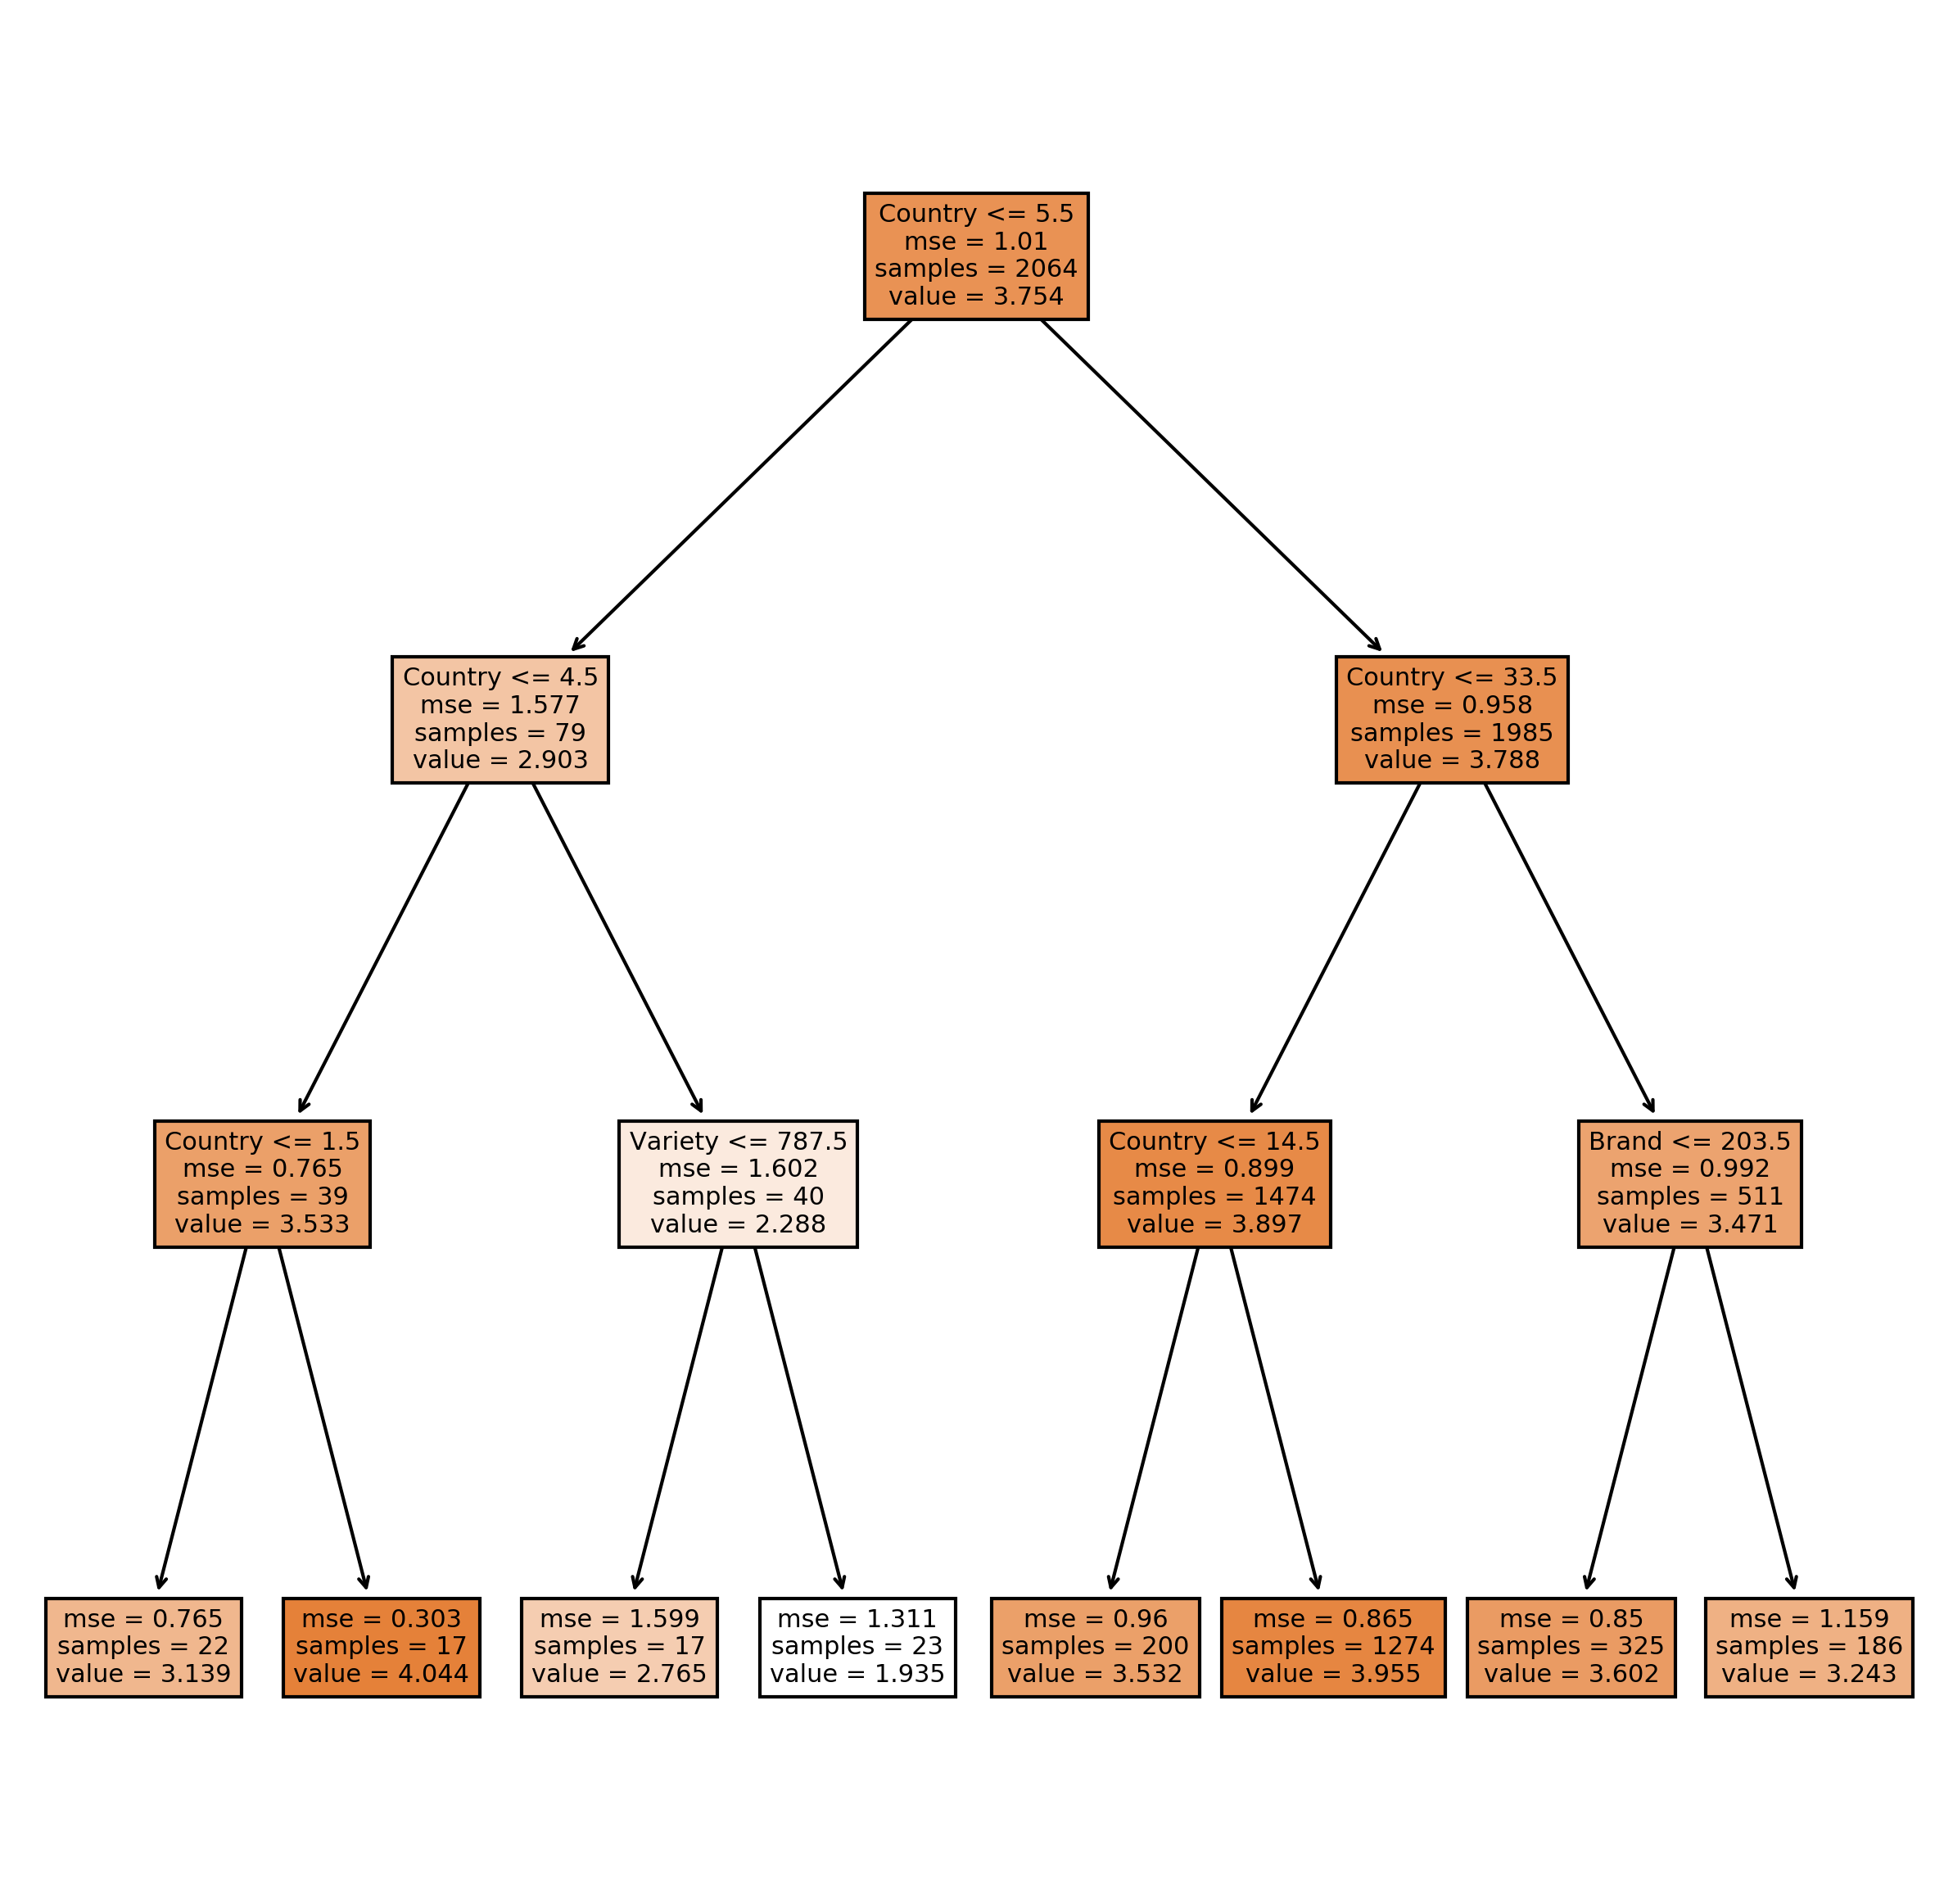

In [43]:
estimator = m.estimators_[0]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(estimator, feature_names=df.columns,filled=True);